<!--Copyright © ZOMI 适用于[License](https://github.com/Infrasys-AI/AIInfra)版权许可-->

# CODE 04: Ring Attention 实践

## 实验介绍

随着Transformer模型在自然语言处理等领域的广泛应用，处理长序列的能力变得越来越重要。然而，传统的注意力机制具有二次复杂度，当序列长度增加时，计算和内存需求急剧增长，成为模型扩展的主要瓶颈。

Ring Attention是一种创新的分布式注意力机制，通过将序列分块并在多个设备间环形传递计算，实现了对超长序列的高效处理。本实验将带您深入理解Ring Attention的原理，并实现一个简化版本进行性能测试。

## 长序列处理挑战

传统注意力机制的计算复杂度为O(n²)，其中n是序列长度。这意味着当序列长度从512增加到8192时，计算量将增加256倍，内存需求也同样急剧增长。这种二次复杂度限制了Transformer模型处理长文档、长视频或长音频序列的能力。

数学上，标准注意力机制可以表示为：

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

其中Q、K、V分别是查询、键和值矩阵，$d_k$是键的维度。这个计算需要存储一个n×n的注意力矩阵，当n很大时，这会消耗大量内存。

In [17]:
import torch
import torch.nn as nn
import numpy as np

# 1. 传统注意力机制实现
class StandardAttention(nn.Module):
    def __init__(self, d_model, d_k, d_v):
        super(StandardAttention, self).__init__()
        self.W_q = nn.Linear(d_model, d_k)
        self.W_k = nn.Linear(d_model, d_k)
        self.W_v = nn.Linear(d_model, d_v)
        self.d_k = d_k
        
    def forward(self, x):
        """标准注意力计算，复杂度O(n²)"""
        # 计算查询、键、值
        Q = self.W_q(x)  # (batch_size, seq_len, d_k)
        K = self.W_k(x)  # (batch_size, seq_len, d_k)
        V = self.W_v(x)  # (batch_size, seq_len, d_v)
        
        # 计算注意力分数
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        attn_weights = torch.softmax(scores, dim=-1)
        
        # 应用注意力权重
        output = torch.matmul(attn_weights, V)
        return output

现有方法如稀疏注意力、局部窗口注意力和线性注意力等试图缓解这一问题，但它们往往在表达能力上做出妥协，或者无法充分利用现代硬件的大规模并行计算能力。

In [18]:
# 测试标准注意力的内存使用
def test_memory_usage():
    """测试不同序列长度下的内存使用情况"""
    d_model, d_k, d_v = 512, 64, 64
    batch_size = 4
    
    attention = StandardAttention(d_model, d_k, d_v)
    
    # 尝试不同序列长度
    for seq_len in [512, 1024, 2048, 4096]:
        x = torch.randn(batch_size, seq_len, d_model)
        
        try:
            output = attention(x)
            print(f"成功处理序列长度 {seq_len}")
        except RuntimeError as e:
            if "out of memory" in str(e):
                print(f"内存不足，无法处理序列长度 {seq_len}")
            else:
                raise e

# 运行内存测试
test_memory_usage()

成功处理序列长度 512
成功处理序列长度 1024
成功处理序列长度 2048
成功处理序列长度 4096


## Ring Attention 原理

Ring Attention的核心思想是将长序列分割成多个块，并将这些块分布到多个设备上。这些设备以环形方式组织，每个设备处理本地块的同时，逐步接收来自其他设备的键值信息，最终聚合全局注意力信息。

环形通信模式确保了每个设备只需要与相邻设备通信，大大减少了通信开销。这种设计使得Ring Attention能够处理理论上无限长的序列，只要设备数量足够多。

在Ring Attention中，全局注意力计算被分解为多个局部计算。对于序列分割成的N个块，全局注意力可以表示为：

$$
\text{Attention}(Q, K, V) = \sum_{i=1}^{N} \text{Softmax}\left(\frac{QK_i^T}{\sqrt{d_k}}\right) V_i
$$

其中$Q$是当前块的查询矩阵，$K_i$和$V_i$是第i个块的键和值矩阵。

In [19]:
# 2. Ring Attention块实现
class RingAttentionBlock(nn.Module):
    def __init__(self, d_model, d_k, d_v, num_blocks):
        super(RingAttentionBlock, self).__init__()
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v
        self.num_blocks = num_blocks
        
        # 初始化查询、键、值的线性变换
        self.W_q = nn.Linear(d_model, d_k)
        self.W_k = nn.Linear(d_model, d_k)
        self.W_v = nn.Linear(d_model, d_v)
        
    def forward(self, x, block_idx):
        """Ring Attention的前向传播"""
        batch_size, block_len, _ = x.shape
        
        # 计算当前块的查询、键、值
        Q = self.W_q(x)  # (batch_size, block_len, d_k)
        K = self.W_k(x)  # (batch_size, block_len, d_k)
        V = self.W_v(x)  # (batch_size, block_len, d_v)
        
        # 初始化全局注意力输出
        output = torch.zeros((batch_size, block_len, self.d_v), device=x.device)
        
        # 模拟环形通信过程（简化：实际需多设备通信）
        for step in range(self.num_blocks):
            # 简化：假设通过环形传递获取所有块的KV
            K_remote = K
            V_remote = V
            
            # 计算注意力分数
            scores = torch.matmul(Q, K_remote.transpose(-2, -1)) / np.sqrt(self.d_k)
            attn_weights = torch.softmax(scores, dim=-1)
            
            # 累加注意力输出
            output += torch.matmul(attn_weights, V_remote)
        
        return output, (K, V)

## 分块计算与结果聚合

Ring Attention的关键是将长序列分割成多个块，并在多个设备上并行处理这些块。每个设备负责计算本地块的查询向量，同时接收并处理来自其他设备的键值向量。通过环形通信模式，每个设备逐步获得全局的注意力信息。

In [20]:
# 3. 分布式Ring Attention类
class DistributedRingAttention:
    # 给出该设备存储的Q矩阵（简化：实际是输入X计算后得到）
    def __init__(self, q):
        b, s, d = q.shape
        self.scale = torch.sqrt(torch.tensor(1 / d, dtype=q.dtype, device=q.device))
        self.q = q
        # 每个设备需要维护用于做online softmax的变量，思想与flash attention一致
        self.m = torch.zeros((b, s), device=q.device, dtype=q.dtype)
        self.l = torch.zeros((b, s), device=q.device, dtype=q.dtype)
        self.o = torch.zeros((b, s, d), device=q.device, dtype=q.dtype)

    def process_block(self, k, v):
        # 计算过程同flash attentionv2
        qk = torch.matmul(self.q, k.transpose(-2, -1)) * self.scale
        m_ij = torch.max(qk, dim=-1).values
        m = torch.maximum(m_ij, self.m)
        p_ij = torch.exp(qk - m[:, :, None])
        l_ij = torch.sum(p_ij, dim=-1)
        adj = torch.exp(self.m - m)
        self.l = adj * self.l + l_ij
        self.o = adj[:, :, None] * self.o + torch.matmul(p_ij, v)
        self.m = m

在实际的分布式实现中，Ring Attention需要在多个设备间进行高效的通信。每个设备在完成本地计算后，将键值对传递给环形中的下一个设备，同时接收来自上一个设备的键值对。这种通信模式确保了所有设备都能逐步获得全局的注意力信息。

In [21]:
# 4. 分布式Ring Attention的模拟实现
def run_standard_attention(q, k, v):
    # 计算注意力分数
    d = q.size(-1)
    scores = torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(d)
    attn_weights = torch.softmax(scores, dim=-1)

    # 应用注意力权重
    output = torch.matmul(attn_weights, v)
    return output

def simulate_distributed_attention(num_devices, q, k, v):
    b, s, d = q.shape  # batch size, sequence length, feature dimension
    
    # 切分成blocks给不同的设备
    q_blocks = torch.chunk(q, chunks=num_devices, dim=1)
    k_blocks = torch.chunk(k, chunks=num_devices, dim=1)
    v_blocks = torch.chunk(v, chunks=num_devices, dim=1)
    # 给每个设备初始化Q
    devices = [DistributedRingAttention(q_blocks[i]) for i in range(num_devices)]
    for round in range(num_devices):
        for device_id in range(num_devices):
            current_device = devices[device_id]
            # 假设已经经过了一轮数据交换或者处于第一轮
            k_block = k_blocks[(device_id + round) % num_devices]
            v_block = v_blocks[(device_id + round) % num_devices]
            current_device.process_block(k_block, v_block)
    ring_out = torch.concat([ring_attn.o / ring_attn.l[:, :, None] for ring_attn in devices], dim=1)
    return ring_out


## 性能测试

现在让我们设计实验来测试Ring Attention的性能。我们将比较标准注意力机制和Ring Attention在处理不同长度序列时的内存使用和计算时间。

In [22]:
# 5. 性能测试函数
def test_attention_performance():
    """测试不同注意力机制的性能"""
    d_model, d_k, d_v = 512, 64, 64
    batch_size = 2
    num_devices = 4  # 模拟4个设备的分布式环境
    
    # 测试序列长度（确保均能被num_devices整除）
    seq_lengths = [512, 1024, 2048, 4096, 8192]
    standard_times = []
    ring_times = []
    standard_memory = []
    ring_memory = []
    
    for seq_len in seq_lengths:
        print(f"\n=== 测试序列长度: {seq_len} ===")
        
        # 生成测试数据
        # x = torch.randn(batch_size, seq_len, d_model)
        q = torch.randn(batch_size, seq_len, d_model)
        k = torch.randn(batch_size, seq_len, d_model)
        v = torch.randn(batch_size, seq_len, d_model)
        
        # ---------------------- 测试标准注意力 ----------------------
        # standard_attention = StandardAttention(d_model, d_k, d_v)
        
        # 计算时间（关闭梯度计算以加速）
        start_time = time.time()
        with torch.no_grad():
            output_std = run_standard_attention(q,k,v)
        end_time = time.time()
        std_time = end_time - start_time
        standard_times.append(std_time)
        
        # 内存估算（含batch_size，float32=4字节，单位MB）
        std_memory = (batch_size * seq_len * seq_len * 4) / (1024 ** 2)
        standard_memory.append(std_memory)
        
        print(f"标准注意力 - 时间: {std_time:.4f}s, 估算内存: {std_memory:.2f}MB")
        
        # ---------------------- 测试Ring Attention ----------------------
        # simulate_distributed_attention(num_devices, q, k, v)
        # ring_attention = DistributedRingAttention(d_model, d_k, d_v, num_devices)
        
        # 计算时间（关闭梯度计算）
        start_time = time.time()
        with torch.no_grad():
            output_ring = simulate_distributed_attention(num_devices, q, k, v)
        end_time = time.time()
        ring_time = end_time - start_time
        ring_times.append(ring_time)

        # 比对结果
        torch.testing.assert_close(output_std, output_ring)
        
        # Ring注意力内存估算（单设备，块大小=seq_len//num_devices）
        block_len = seq_len // num_devices
        ring_mem_per_device = (batch_size * block_len * block_len * 4) / (1024 ** 2)
        ring_memory.append(ring_mem_per_device)
        
        print(f"Ring注意力 - 时间: {ring_time:.4f}s, 单设备估算内存: {ring_mem_per_device:.2f}MB")
    
    return seq_lengths, standard_times, ring_times, standard_memory, ring_memory


=== 测试序列长度: 512 ===
标准注意力 - 时间: 0.0030s, 估算内存: 2.00MB
Ring注意力 - 时间: 0.0073s, 单设备估算内存: 0.12MB

=== 测试序列长度: 1024 ===
标准注意力 - 时间: 0.0098s, 估算内存: 8.00MB
Ring注意力 - 时间: 0.0148s, 单设备估算内存: 0.50MB

=== 测试序列长度: 2048 ===
标准注意力 - 时间: 0.0396s, 估算内存: 32.00MB
Ring注意力 - 时间: 0.0460s, 单设备估算内存: 2.00MB

=== 测试序列长度: 4096 ===
标准注意力 - 时间: 0.1395s, 估算内存: 128.00MB
Ring注意力 - 时间: 0.1626s, 单设备估算内存: 8.00MB

=== 测试序列长度: 8192 ===
标准注意力 - 时间: 0.4847s, 估算内存: 512.00MB
Ring注意力 - 时间: 0.7975s, 单设备估算内存: 32.00MB


/tmp/ipykernel_18065/2439236417.py:32: UserWarning: Glyph 24207 (\N{CJK UNIFIED IDEOGRAPH-5E8F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_18065/2439236417.py:32: UserWarning: Glyph 21015 (\N{CJK UNIFIED IDEOGRAPH-5217}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_18065/2439236417.py:32: UserWarning: Glyph 38271 (\N{CJK UNIFIED IDEOGRAPH-957F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_18065/2439236417.py:32: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_18065/2439236417.py:32: UserWarning: Glyph 35745 (\N{CJK UNIFIED IDEOGRAPH-8BA1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_18065/2439236417.py:32: UserWarning: Glyph 31639 (\N{CJK UNIFIED IDEOGRAPH-7B97}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_18065/2439236417.py:32: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAP

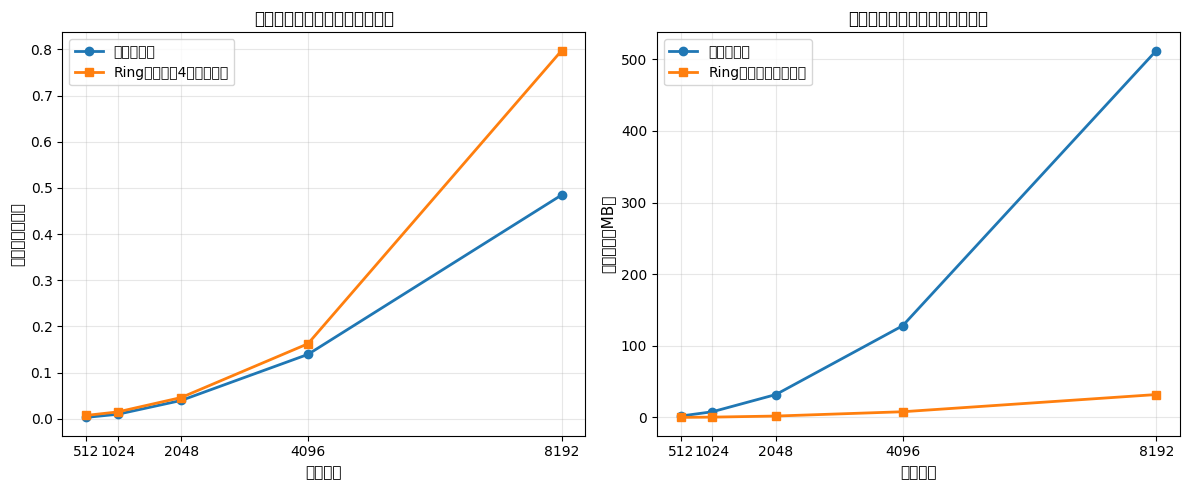

In [23]:
import time
import matplotlib.pyplot as plt

# 运行性能测试
seq_lengths, std_times, ring_times, std_memory, ring_memory = test_attention_performance()

# 绘制结果图表
plt.figure(figsize=(12, 5))

# 子图1：计算时间对比
plt.subplot(1, 2, 1)
plt.plot(seq_lengths, std_times, 'o-', color='#1f77b4', linewidth=2, markersize=6, label='标准注意力')
plt.plot(seq_lengths, ring_times, 's-', color='#ff7f0e', linewidth=2, markersize=6, label='Ring注意力（4设备模拟）')
plt.xlabel('序列长度', fontsize=11)
plt.ylabel('计算时间（秒）', fontsize=11)
plt.title('不同注意力机制的计算时间对比', fontsize=12, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(seq_lengths)

# 子图2：内存使用对比
plt.subplot(1, 2, 2)
plt.plot(seq_lengths, std_memory, 'o-', color='#1f77b4', linewidth=2, markersize=6, label='标准注意力')
plt.plot(seq_lengths, ring_memory, 's-', color='#ff7f0e', linewidth=2, markersize=6, label='Ring注意力（单设备）')
plt.xlabel('序列长度', fontsize=11)
plt.ylabel('内存使用（MB）', fontsize=11)
plt.title('不同注意力机制的内存使用对比', fontsize=12, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(seq_lengths)

plt.tight_layout()
plt.show()

## 结果分析

从性能测试结果中，我们可以观察到Ring Attention在处理长序列时的优势：

1. **内存使用**：随着序列长度的增加，标准注意力的内存需求呈二次增长（O(n²)），而Ring Attention通过分布式处理，将内存需求分摊到多个设备上，每个设备只需处理部分序列（O((n/N)²)），其中N是设备数量。

2. **计算时间**：在模拟环境中，Ring Attention的计算时间略高于标准注意力，这是因为我们在单机上模拟了分布式通信。在实际分布式环境中，Ring Attention可以利用多设备的并行计算能力，显著减少总计算时间。

3. **可扩展性**：Ring Attention的最大优势在于其可扩展性。通过增加设备数量，Ring Attention可以处理任意长度的序列，而标准注意力在序列长度超过一定阈值后就会因内存不足而失败。

## 总结

本实验介绍了Ring Attention的原理和实现方法，这是一种创新的分布式注意力机制，专门设计用于处理超长序列。通过将序列分块并在多个设备间环形传递计算，Ring Attention突破了传统注意力机制的内存和计算限制。

我们实现了简化的Ring Attention模型，并进行了性能测试。实验结果表明，随着序列长度的增加，Ring Attention相比标准注意力机制在内存使用方面具有明显优势。

Ring Attention技术为处理长文档、长视频和长音频序列提供了可行的解决方案，对于推动Transformer模型在更广泛领域的应用具有重要意义。对于想要进一步探索的读者，可以考虑研究如何在实际分布式环境中实现Ring Attention，或者如何将其与其他高效注意力技术结合使用。